# ***Classification automatique sur la colonne contenant les textes tokenisés sans les noms des personnages (3 tags)***

# Imports

In [ ]:
# Imports nécessaires

%matplotlib inline

# Suppression de l'affichage des messages d'avertissement
import warnings
warnings.filterwarnings('ignore')
import string
import time
from sklearn import metrics
from sklearn import model_selection
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

# Pour la visualisation des pipelines sklearn
set_config(display='diagram')


# Chargement des données

In [ ]:
# Création d'un dossier appelé data
!mkdir data
# Téléchargement du fichier dev dans le dossier data
!wget -P data https://gitlab.unistra.fr/paulinemoreau/memoire/-/raw/main/data/vrac/classification/fanfics_dev.csv

mkdir: cannot create directory ‘data’: File exists
--2025-03-21 17:32:14--  https://gitlab.unistra.fr/paulinemoreau/memoire/-/raw/main/data/vrac/classification/fanfics_dev.csv
Resolving gitlab.unistra.fr (gitlab.unistra.fr)... 130.79.254.48
Connecting to gitlab.unistra.fr (gitlab.unistra.fr)|130.79.254.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 471015192 (449M) [text/plain]
Saving to: ‘data/fanfics_dev.csv.1’

fanfics_dev.csv.1   100%[===================>] 449.19M  21.5MB/s    in 21s     

2025-03-21 17:32:36 (21.1 MB/s) - ‘data/fanfics_dev.csv.1’ saved [471015192/471015192]



In [ ]:
# Lecture des fichiers
dtypes = {'title': 'object',
          'tokenised_no_chara': 'object',
          'tag': 'category'}

df_dev = pd.read_csv('data/fanfics_dev.csv', dtype=dtypes)

In [ ]:
df_dev.head()

,work_id,tag,title,author,rating,category,fandom,relationship,character,additional tags,...,all_bookmarks,body,body_clean,nb_caracteres,characters_clean,body_no_chara,tokenised_body,tokenised_no_chara,lemmatised_body,lemmatised_no_chara
0,63528274,Fluff,Je le deteste,['wilk'],Not Rated,M/M,Hawaii Five-0 (2010),"Steve McGarrett/Danny ""Danno"" Williams","Danny ""Danno"" Williams, Steve McGarrett",Fluff,...,[],Danny deteste vraiment Steve : a peine deux jo...,Danny deteste vraiment Steve : a peine deux jo...,600,"['Steve', 'Williams', 'Danny', 'McGarrett', 'D...",deteste vraiment : a peine deux jours apres ...,Danny deteste vraiment Steve : peine jours ren...,"deteste vraiment : peine jours rencontre ,...",Danny detest vraiment steve : avoir peine deux...,detest vraiment : avoir peine deux jour ap...
1,63496033,Fluff,Bout de chair,['AndrewClawd'],Not Rated,M/M,"Marvel Cinematic Universe, Marvel, The Falcon ...","James ""Bucky"" Barnes/Helmut Zemo","James ""Bucky"" Barnes, Helmut Zemo, Sam Wilson ...","Slow Romance, Slow Burn, Nebulous Zemo Parole ...",...,[],Encore une reunion fatigante et lassante... Le...,Encore une reunion fatigante et lassante... Le...,4711,"['Hill', 'Maria', 'Bucky', 'James', 'Joaquin',...",Encore une reunion fatigante et lassante... Le...,reunion fatigante lassante ... rapports docume...,reunion fatigante lassante ... rapports docume...,encore un reunion fatigant et lassant ... le r...,encore un reunion fatigant et lassant ... le r...
2,62666845,Fluff,Un amour,['MarinaKaFai'],Teen And Up Audiences,F/M,House of the Dragon (TV),"Floris Baratheon/Aemond ""One-Eye"" Targaryen","Floris Baratheon, Aemond ""One-Eye"" Targaryen","Romance, Friendship, Friendship/Love, Modern E...",...,[],"Aemond n'est pas tres porte sur les soirees, l...","Aemond n'est pas tres porte sur les soirees, l...",41867,"['One-Eye', 'Baratheon', 'Floris', 'Targaryen'...","n'est pas tres porte sur les soirees, les fet...","Aemond porte soirees , fetes . prefere , lire ...","porte soirees , fetes . prefere , lire , fai...","Aemond ne être pas tres porte sur le soiree , ...","ne être pas tres porte sur le soiree , le fe..."
3,55335970,Fluff,On ne rigole pas avec l'amour (Mais on peut av...,['Wekake'],Explicit,M/M,Harry Potter - J. K. Rowling,Neville Longbottom/George Weasley,"George Weasley, Neville Longbottom, Augusta Lo...","Fluff, Fluff and Humor, Humor, Attempt at Humo...",...,[],Sa chevelure etait de plus en plus hideuse. Ge...,Sa chevelure etait de plus en plus hideuse. Ge...,65083,"['Weasley', 'Ginny', 'Lee', 'Draco', 'George',...",Sa chevelure etait de plus en plus hideuse. g...,chevelure hideuse . George glissa doigts meche...,chevelure hideuse . glissa doigts meches tir...,son chevelure eter de plus en plus hideux . ge...,son chevelure eter de plus en plus hideux . ...
4,63372115,Fluff,Shampoing [FRANCAIS],['wigglycaterpillar'],Teen And Up Audiences,M/M,Haikyuu!!,Akaashi Keiji/Bokuto Koutarou,"Akaashi Keiji, Bokuto Koutarou","Established Relationship, Aged-Up Character(s)...",...,[],Bokuto etait allonge sur le canape et se faisa...,Bokuto etait allonge sur le canape et se faisa...,7577,"['Akaashi', 'Keiji', 'Bokuto', 'Koutarou']",etait allonge sur le canape et se faisait des...,Bokuto allonge canape faisait passes - lorsqu'...,allonge canape faisait passes - lorsqu' ente...,Bokuto eter allonger sur le canape et se faire...,eter allonger sur le canape et se faire un p...


# Sélectionner uniquement les 3 principaux tags

In [ ]:
# Filtrer les données pour ne conserver que les trois tags d'intérêt
tags_of_interest = ['Fluff', 'Angst', 'Hurt/Comfort']
df_dev_filtre = df_dev[df_dev['tag'].isin(tags_of_interest)]

# Apprentissage des catégories
Utilisation de la colonne 'tokenised_no_chara' (textes tokenisés sans noms des personnages).

In [ ]:
# Données sources
X_dev = df_dev_filtre['tokenised_no_chara']

# Données à prédire
y_dev = df_dev_filtre.tag

# Vectorisation TF-IDF

In [ ]:
# Découpage des textes en listes de mots
def split_text(text) :
  # Les textes ayant déjà été pré-tokénisés, il suffit de les découper au niveau des espaces
  return text.split(' ')

In [ ]:
# Objet TfidfVectorizer
text_vectorizer = TfidfVectorizer(tokenizer=split_text, min_df=0.01)

# Entrainement des modèles en validation croisée

Baseline
              precision    recall  f1-score   support

       Angst       0.35      1.00      0.52       727
       Fluff       0.00      0.00      0.00       617
Hurt/Comfort       0.00      0.00      0.00       716

    accuracy                           0.35      2060
   macro avg       0.12      0.33      0.17      2060
weighted avg       0.12      0.35      0.18      2060

Mutinomial NB
              precision    recall  f1-score   support

       Angst       0.79      0.57      0.67       727
       Fluff       0.95      0.28      0.43       617
Hurt/Comfort       0.49      0.93      0.64       716

    accuracy                           0.61      2060
   macro avg       0.74      0.59      0.58      2060
weighted avg       0.73      0.61      0.59      2060

CART
              precision    recall  f1-score   support

       Angst       0.58      0.57      0.57       727
       Fluff       0.58      0.59      0.58       617
Hurt/Comfort       0.51      0.52      0.51    

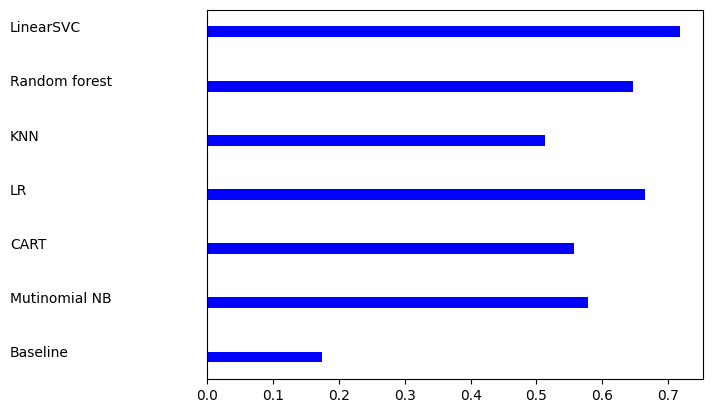

In [ ]:
# Modèles à comparer
models = [
    ('Baseline', DummyClassifier(strategy='most_frequent')),
    ('Mutinomial NB', MultinomialNB()),
    ('CART', DecisionTreeClassifier()),
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Random forest', RandomForestClassifier()),
    ('LinearSVC', LinearSVC()),
]
# Evaluation de chaque résultat l'un après l'autre
scores = []
names = []
scoring = 'macro F1'
# Validation croisée à 5 plis
kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
# Itération sur les modèles
for name, model in models:
    # Ajout du nom du modèle à la liste name
    names.append(name)
    # Création de la pipeline pour le modèle
    model_pipeline = make_pipeline(text_vectorizer, model)
    # Validation croisée
    y_pred = model_selection.cross_val_predict(model_pipeline,
                                               X_dev, y_dev,
                                               cv=kfold)
    print(name)
    print(classification_report(y_dev, y_pred))
    f1 = metrics.f1_score(y_dev, y_pred, average='macro')
    scores.append(f1)

# Représentation graphique des résultats
indices = np.arange(len(scores))
fig = plt.figure()
plt.barh(indices, scores, .2, label="score", color='b')
plt.yticks(())
for i, c in zip(indices, names):
    plt.text(-.3, i, c)
plt.show()

# Premier aperçu des caractéristiques discriminantes selon LinearSVC
Je réentraine le modèle le plus performant qui est LinearSVC puis récupère les coefficients du modèle pour avoir une première idée des caractéristiques de chaque tag identifiées par le modèle et s'assurer que les résultats semblent pertinents.

In [ ]:
# Entraînement du modèle avec pipeline
model_pipeline = make_pipeline(text_vectorizer, LinearSVC())
model_pipeline.fit(X_dev, y_dev)

# Récupérer le vecteur TF-IDF
feature_names = text_vectorizer.get_feature_names_out()

# Récupérer les coefficients du modèle
coefs = model_pipeline.named_steps['linearsvc'].coef_

# Associer les coefficients aux mots du vocabulaire
coef_df = pd.DataFrame(coefs, columns=feature_names, index=model_pipeline.named_steps['linearsvc'].classes_)

# Afficher les 10 mots les plus discriminants pour chaque classe
for tag in coef_df.index:
    print(f"\nTop 10 mots pour {tag} :")
    print(coef_df.loc[tag].nlargest(10))  # 10 plus grands coefficients


Top 10 mots pour Angst :
sang       1.908097
corps      1.766017
mort       1.575061
douleur    1.562956
rien       1.489409
devait     1.317365
savait     1.311195
bite       1.281135
tom        1.274485
mere       1.268175
Name: Angst, dtype: float64

Top 10 mots pour Fluff :
sourire      3.967120
sourit       2.285494
rire         1.956330
noel         1.886202
enfants      1.461641
d            1.433930
alpha        1.417318
-tu          1.385953
embrasser    1.351386
idee         1.325234
Name: Fluff, dtype: float64

Top 10 mots pour Hurt/Comfort :
:             2.124087
larmes        1.691246
brun          1.486792
docteur       1.416071
sais          1.393453
maitre        1.355081
coeur         1.319930
ailleurs      1.271007
bras          1.217314
expression    1.213876
Name: Hurt/Comfort, dtype: float64


# Entrainement des modèles sur les textes sans ponctuation
### Fonction qui supprime la ponctuation d'un texte

J'applique la fonction 'nettoyer_sans_ponctuation' à la colonne utilisée précédemment pour l'entrainement des modèles, soit 'tokenised_no_chara', pour créer la colonne 'tokenised_no_chara_no_punct' qui contient les textes tokenisés sans ponctuation.

In [ ]:
import string

def nettoyer_sans_ponctuation(texte):
    # Supprimer la ponctuation
    return texte.translate(str.maketrans('', '', string.punctuation))

# Appliquer cette fonction sur la colonne
df_dev_filtre['tokenised_no_chara_no_punct'] = df_dev_filtre['tokenised_no_chara'].apply(nettoyer_sans_ponctuation)

In [ ]:
df_dev_filtre[['tokenised_no_chara', 'tokenised_no_chara_no_punct']].head()

,tokenised_no_chara,tokenised_no_chara_no_punct
0,"deteste vraiment : peine jours rencontre ,...",deteste vraiment peine jours rencontre j...
1,reunion fatigante lassante ... rapports docume...,reunion fatigante lassante rapports documents...
2,"porte soirees , fetes . prefere , lire , fai...",porte soirees fetes prefere lire faire a...
3,chevelure hideuse . glissa doigts meches tir...,chevelure hideuse glissa doigts meches tira...
4,allonge canape faisait passes - lorsqu' ente...,allonge canape faisait passes lorsqu entend...


In [ ]:
# Données sources
X_dev_punct = df_dev_filtre['tokenised_no_chara_no_punct']

# Données à prédire
y_dev_punct = df_dev_filtre.tag

Baseline
              precision    recall  f1-score   support

       Angst       0.35      1.00      0.52       727
       Fluff       0.00      0.00      0.00       617
Hurt/Comfort       0.00      0.00      0.00       716

    accuracy                           0.35      2060
   macro avg       0.12      0.33      0.17      2060
weighted avg       0.12      0.35      0.18      2060

Mutinomial NB
              precision    recall  f1-score   support

       Angst       0.70      0.68      0.69       727
       Fluff       0.99      0.17      0.28       617
Hurt/Comfort       0.48      0.83      0.61       716

    accuracy                           0.58      2060
   macro avg       0.72      0.56      0.53      2060
weighted avg       0.71      0.58      0.54      2060

CART
              precision    recall  f1-score   support

       Angst       0.57      0.56      0.56       727
       Fluff       0.55      0.56      0.55       617
Hurt/Comfort       0.50      0.51      0.50    

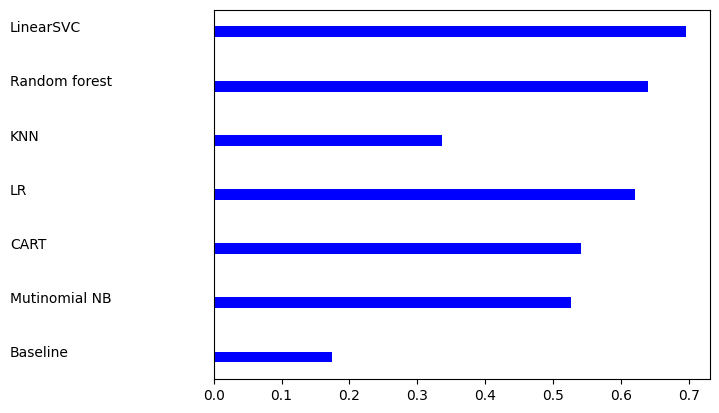

In [ ]:
# Modèles à comparer
models = [
    ('Baseline', DummyClassifier(strategy='most_frequent')),
    ('Mutinomial NB', MultinomialNB()),
    ('CART', DecisionTreeClassifier()),
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Random forest', RandomForestClassifier()),
    ('LinearSVC', LinearSVC()),
]
# Evaluation de chaque résultat l'un après l'autre
scores = []
names = []
scoring = 'macro F1'
# Validation croisée à 5 plis
kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
# Itération sur les modèles
for name, model in models:
    # Ajout du nom du modèle à la liste name
    names.append(name)
    # Création de la pipeline pour le modèle
    model_pipeline = make_pipeline(text_vectorizer, model)
    # Validation croisée
    y_pred = model_selection.cross_val_predict(model_pipeline,
                                               X_dev_punct, y_dev_punct,
                                               cv=kfold)
    print(name)
    print(classification_report(y_dev_punct, y_pred))
    f1 = metrics.f1_score(y_dev_punct, y_pred, average='macro')
    scores.append(f1)

# Représentation graphique des résultats
indices = np.arange(len(scores))
fig = plt.figure()
plt.barh(indices, scores, .2, label="score", color='b')
plt.yticks(())
for i, c in zip(indices, names):
    plt.text(-.3, i, c)
plt.show()